# Boundary Attack
[Wieland Brendel et al. in “Decision-Based Adversarial Attacks: Reliable Attacks Against Black-Box Machine Learning Models” (2018)](https://arxiv.org/abs/1712.04248).

# 1. 事前準備と確認

## 必要なライブラリのインポート

In [1]:
from imagenet_util import *

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

## ResNet50 を生成

In [2]:
model = ResNet50(weights='imagenet')

Run the test images through it.

## オリジナル画像のロードと表示

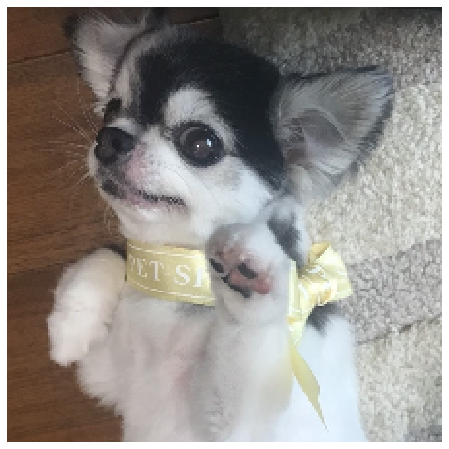

In [3]:
original_image_path = '../../images/chihuahua2.jpg'
original_image = load_img(original_image_path, target_size=(224, 224))
original_image = img_to_array(original_image)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(original_image/255.0)

## オリジナル画像の正規化

In [20]:
norm_original_image = preprocess_input(original_image.copy())

## オリジナル画像の推論と分類

In [5]:
Y_hat = model.predict(np.expand_dims(norm_original_image, 0)) # 推論
original_class, original_name, original_score = get_top_pred(Y_hat) # 分類
print('Prediction: {0} - score {1:.2f}%'.format(original_name, original_score * 100)) # 分類結果とスコアを表示

Prediction: Chihuahua - score 67.11%


## スタート画像のロードと表示

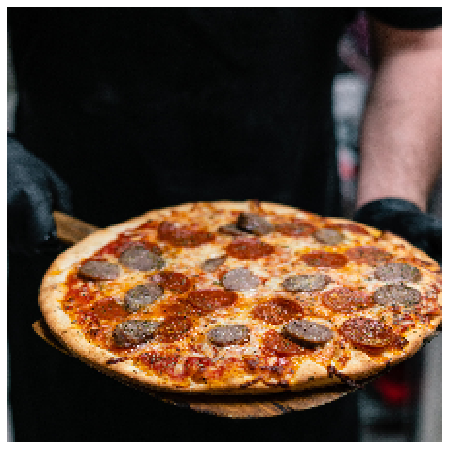

In [6]:
start_image_path = '../../images/pizza.jpg'
start_image = load_img(start_image_path, target_size=(224, 224))
start_image = img_to_array(start_image)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(start_image/255.0)

## スタート画像の正規化

In [7]:
norm_start_image = preprocess_input(start_image.copy())

## スタート画像の推論と分類

In [8]:
Y_hat_start = model.predict(np.expand_dims(norm_start_image, 0)) # 推論
start_class, start_name, start_score = get_top_pred(Y_hat_start) # 分類

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(start_name, start_score * 100))

Prediction: pizza - score 98.43%


# 2. BoundaryAttack クラス開発

## BoundaryAttack クラス

In [10]:
class BoundaryAttack:
    """ BoundaryAttack
    Attributes:
        classifier (Model) : モデル
        delta (float): S1での移動量を調整するハイパーパラメータ
        epsilon (float): S2での移動量を調整するハイパーパラメータ
        step_adapt (float): delta, epsilon を調整するためのハイパーパラメータ
        max_step_size (int): 最大ステップ回数
        max_trial_size (int): 1回のステップで S1と S2 を試行する最大回数
        sample_size (float): S1 のサンプル数
        lower_success_rate (float): 成功率の下限値。これを下回ると、delta または epsilon が調整される。
        upper_success_rate (float): 成功率の上限値。これを上回ると、delta または epsilon が調整される。
    """

    def __init__(self, 
                 classifier, 
                 delta = 0.01,
                 epsilon = 0.01, 
                 step_adapt = 0.667, 
                 max_step_size = 10, 
                 max_trial_size = 25, 
                 sample_size = 20,
                 lower_success_rate = 0.2,
                 upper_success_rate = 0.5):

        # インスタンス変数をセット
        self.classifier = classifier
        self.delta = delta
        self.epsilon = epsilon
        self.step_adapt = step_adapt
        self.max_step_size = max_step_size
        self.max_trial_size = max_trial_size
        self.sample_size = sample_size
        self.lower_success_rate = lower_success_rate
        self.upper_success_rate = upper_success_rate
    
    def orthogonal_vector(self, current_image, original_image):
        """
        S1のベクトル s1を計算する
        Args:
            current_image (ndarray): 現在の敵対的サンプル `(224, 224, 3)`
            original_image (ndarray): オリジナル画像 `(224, 224, 3)`
        Returns:
            vec_s1 (ndarray): ベクトル s1 `(224, 224, 3)`
        """

        # ① ランダムにベクトルを生成
        vec = np.random.randn(*current_image.shape).astype(np.float32)

        # ② オリジナル画像を始点、現在の敵対的サンプルを終点とするベクトルを生成
        vec_co = current_image - original_image
        
        # ③ vec_co の大きさを1にする
        vec_co /= np.linalg.norm(vec_co)
        
        # ④ vec と vec_co の内積を計算
        dot = np.vdot(vec, vec_co)
        
        # ⑤ vec_co を dot でスカラー倍する
        vec_co *= dot
        
        # ⑥ vec を現在の敵対的サンプルを接点とする接線上に移動させる
        vec -= vec_co
        
        # ⑦ vec の大きさを delta * r  にする
        r = np.linalg.norm(original_image - current_image)
        vec *= self.delta * r / np.linalg.norm(vec)
        
        # ⑧ vec と半径の斜辺の長さを計算する
        h = r * np.sqrt(1 + self.delta ** 2)
        
        # ⑨ vec の終点を円周上に移動させたベクトルを計算する
        vec_s1 = ((r - h) * (current_image - original_image) + r * vec) / h

        # ベクトル s1を返す
        return vec_s1
    
    def generate(self, original_image, target_class, start_image):
        """
        敵対的サンプルを生成する
        Args:
            original_image (ndarray): オリジナル画像 `(224, 224, 3)`
            target_class (int): ターゲットクラス
            start_image (ndarray): スタート画像 `(224, 224, 3)`
        Returns:
            current_image (ndarray): 敵対的サンプル `(224, 224, 3)`
        """

        # スタート画像を現在の敵対的サンプルとしてセット
        current_image = start_image

        # step_size　回のステップを実行
        for _ in range(self.max_step_size):
            
            # S1の試行。S2に進む候補が見つかるまで、最大 max_trial_size　回の試行を行う
            for _ in range(self.max_trial_size):
                
                # 候補を格納するリスト
                potential_advs = []

                # vec_s1 をサンプル数だけ生成
                for _ in range(self.sample_size):
                    
                    # ベクトル s1を計算
                    vec_s1 = self.orthogonal_vector(current_image, original_image)
                    
                    # 現在の敵対的サンプルに vec_s1 を加算、クリッピングし、候補に加える
                    potential_adv = current_image + vec_s1
                    potential_adv = np.clip(potential_adv, 0, 255.0)
                    potential_advs.append(potential_adv)

                # 候補リストを ndarray に変換
                potential_advs = np.array(potential_advs)
                
                # すべての候補の分類結果を取得 `(sample_size, )`
                potential_advs_classes = np.argmax(self.classifier.predict(preprocess_input(potential_advs.copy())), axis=1)
                
                # 成功した候補を　True、失敗した候補を False で管理 `(sample_size, )`
                satisfied = potential_advs_classes == target_class
                
                # S1の成功率を計算。 np.mean で （True の数 / 要素数）　を計算する
                success_ratio = np.mean(satisfied)

                # 成功率が低い場合は　delta を小さくする
                if success_ratio < self.lower_success_rate:
                    self.delta *= self.step_adapt
                
                # 成功率が高い場合は　delta を大きくする
                elif success_ratio > self.upper_success_rate:
                    self.delta /= self.step_adapt

                # 1つでも成功すれば、
                # 成功した候補を全て　adv_images に格納し、S2まで進める
                if success_ratio > 0:
                    adv_images = np.array(potential_advs)[np.where(satisfied)[0]]
                    break
                else:
                    # 1つも成功しなければ、次の試行に移る。
                    # 次の試行では小さくなった delta を利用するため、成功しやすくなる
                    continue
            
            # max_trial_size 回 S1を試行して、
            # 1つも成功しなければ、現在の敵対的サンプルを返す
            else:
                return current_image

            # S2の試行。敵対的サンプル（次のステップでの「現在の敵対的サンプル」）が見つかるまで、最大 max_trial_size　回の試行を行う
            for _ in range(self.max_trial_size):
                
                # オリジナル画像と S1後の候補リスト  (adv_images)  内の各候補との差分に epsilon 倍して、ベクトル s2 を計算する
                # (original_image - adv_images) はブロードキャストによる演算がなされる
                # vec_s2s は各候補に対するベクトルs2を格納する配列となる
                vec_s2s =  self.epsilon * (original_image - adv_images) # `(S1後の候補リストのサイズ, 224, 224, 3)`
                
                # ベクトル s2 を　adv_images に加算し、クリッピングし、候補とする
                potential_advs = adv_images + vec_s2s
                potential_advs = np.clip(potential_advs, 0, 255.0)
                
                # S2の成功率を計算
                potential_advs_classes = np.argmax(self.classifier.predict(preprocess_input(potential_advs.copy())), axis=1)
                satisfied = potential_advs_classes == target_class
                success_ratio = np.mean(satisfied)

                # 成功率が低い場合は　epsilon を小さくする
                if success_ratio < self.lower_success_rate:
                    self.epsilon *= self.step_adapt
                    
                # 成功率が高い場合は　epsilon を大きくする
                elif success_ratio > self.upper_success_rate:
                    self.epsilon /= self.step_adapt

                # 1つでも成功すれば、
                # 候補の1つを敵対的サンプル（次のステップの現在の敵対的サンプル）とする
                if success_ratio > 0:
                    # 攻撃対象のサービスが分類結果のみを返すと想定し、
                    # シンプルに1つ目の候補を敵対的サンプルとする
                    potential_advs = potential_advs[np.where(satisfied)[0]]
                    current_image = potential_advs[0]   
                    break
                else:
                    # 1つも成功しなければ、次の試行に移る。
                    # 次の試行では小さくなった epsilon を利用するため、成功しやすくなる
                    continue
 
            # max_trial_size　回　S2を試行して、
            # 1つも成功しなければ、S2 まで進んでいる候補リストの中から最初の候補を返す
            else:
                return adv_images[0]

        # 敵対的サンプルを返す
        return current_image

# 3. 敵対的サンプルの生成と攻撃

## 敵対的サンプルの生成と攻撃

0 Steps: L2 = 40725.74, class = pizza  


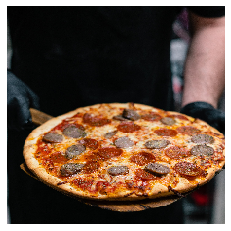

50 Steps: L2 = 12283.65, class = pizza  


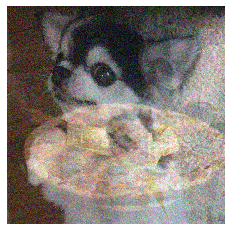

In [12]:
# スタート画像を現在の敵対的サンプルとして設定
adv_image = start_image

# ターゲットクラスを設定
target_class = start_class

# ループごとの敵対的サンプルを格納しておくリスト
adv_image_list = []

# ループごとの最大ステップ回数
max_step_size = 50

# 乱数のシードを設定
np.random.seed(1)

# BoundaryAttack のインスタンスを生成
# 初回のループはステップ回数を0とする
attack = BoundaryAttack(model, max_step_size = 0)

# loop_size を設定
loop_size = 2

# loop_size の数だけ generate メソッドを呼び出す
for i in range(loop_size):

    # 敵対的サンプルの生成
    adv_image = attack.generate(original_image, target_class, adv_image)
    
    # オリジナルと敵対的サンプルの差の L2 を計算
    L2 = np.linalg.norm(adv_image - original_image)
    
    # 現在のトータルステップ数を計算
    step = i * max_step_size
    
    # 推論
    Y_hat_adv = model.predict(np.expand_dims(preprocess_input(adv_image.copy()), axis=0))
    
    # 分類
    _, adv_name, _ = get_top_pred(Y_hat_adv)
    
    # 現在のトータルステップ数と敵対的サンプルを保存
    adv_image_list.append([step, adv_image])
    
    # 現在のトータルステップ数、L2、分類結果を表示
    print("{0} Steps: L2 = {1:.2f}, class = {2}  ".format(step, L2, adv_name)) 
    
    # 敵対的サンプルの表示
    plt.axis('off')
    plt.imshow(adv_image/255.0)
    plt.show()
    
    # max_step_size を設定
    attack.max_step_size = max_step_size

## 画像の表示

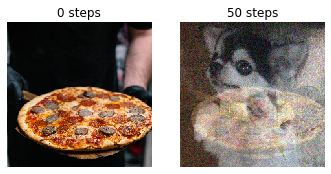

In [13]:
plt.figure(figsize=(15, 5))
col = 5
row = (len(adv_image_list) - 1) // col + 1
num = 0
while num < len(adv_image_list):
    plt.subplot(row, col,  num + 1)
    plt.axis('off')
    plt.title('{} steps'.format(adv_image_list[num][0]))
    plt.imshow(adv_image_list[num][1]/255.0)
    num += 1

# 4. 筆者の実行結果のロードと表示

## adv_image_list の保存 （実行しないでください）

In [35]:
# np.save('../../data/chihuahua_boundary', np.array(adv_image_list), allow_pickle=True)

## 筆者の実行結果をロード

In [9]:
loaded_adv_image_list = np.load('../../data/chihuahua_boundary.npy', allow_pickle=True)

## 筆者の実行結果を表示

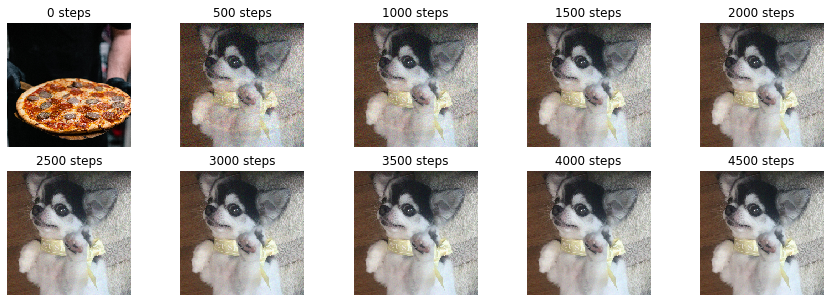

In [10]:
plt.figure(figsize=(15, 5))
col = 5
row = (len(loaded_adv_image_list) - 1) // col + 1
num = 0
while num < len(loaded_adv_image_list):
    plt.subplot(row, col,  num + 1)
    plt.axis('off')
    plt.title('{} steps'.format(loaded_adv_image_list[num][0]))
    plt.imshow(loaded_adv_image_list[num][1]/255.0)
    num += 1